In [1]:
import os
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.nn.utils import prune
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

In [4]:
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [5]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In [6]:
def global_unstructure_prune(model, pruning_amount=0.2):

    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount
    )

    # Make the pruning permanent
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

In [7]:
# Function to update learning rate
def adjust_learning_rate(optimizer, current_batch, total_batches, initial_lr):
    """Sets the learning rate for warmup over total_batches"""
    lr = initial_lr * (current_batch / total_batches)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
def unlearning(net, retain, forget, validation, num_layers_to_finetune=1):
    
    # Freeze the first N-X layers
    # ct = 0
    # for name, param in net.named_parameters():
    #     ct += 1
    #     if ct < num_layers_to_finetune:
    #         param.requires_grad = False
    #     else:
    #         param.requires_grad = True

    # Apply pruning
    pct = 0.99
    global_unstructure_prune(net, pct)

    epochs = 2
    total_samples = len(retain.dataset)
    batch_size = retain.batch_size
    batches_per_epoch  = math.ceil(total_samples / batch_size)
    total_batches = epochs * batches_per_epoch
    initial_lr = 0.01
    warmup_batches = math.ceil(0.4*batches_per_epoch)

    current_batch = 0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [18]:
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)

# Execute the unlearing routine. This might take a few minutes.
# If run on colab, be sure to be running it on  an instance with GPUs
ft_model = unlearning(ft_model, retain_loader, forget_loader, val_loader)

2 epochs - 0.02 LR:
- Retain set accuracy: 98.9%
- Forget set accuracy: 94.3%
- Test set accuracy: 86.5%

In [19]:
print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 97.5%
Forget set accuracy: 89.5%
Test set accuracy: 85.3%


# 🏅 Evaluation

In [77]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

In [78]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

As a reference point, we first compute the accuracy of the MIA on the original model to distinguish between the forget set and the test set.

In [79]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.580 on forgotten vs unseen images


We'll now compute the accuracy of the MIA on the unlearned model. We expect the MIA to be less accurate on the unlearned model than on the original model, since the original model has not undergone a procedure to unlearn the forget set.

In [80]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [81]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.519 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

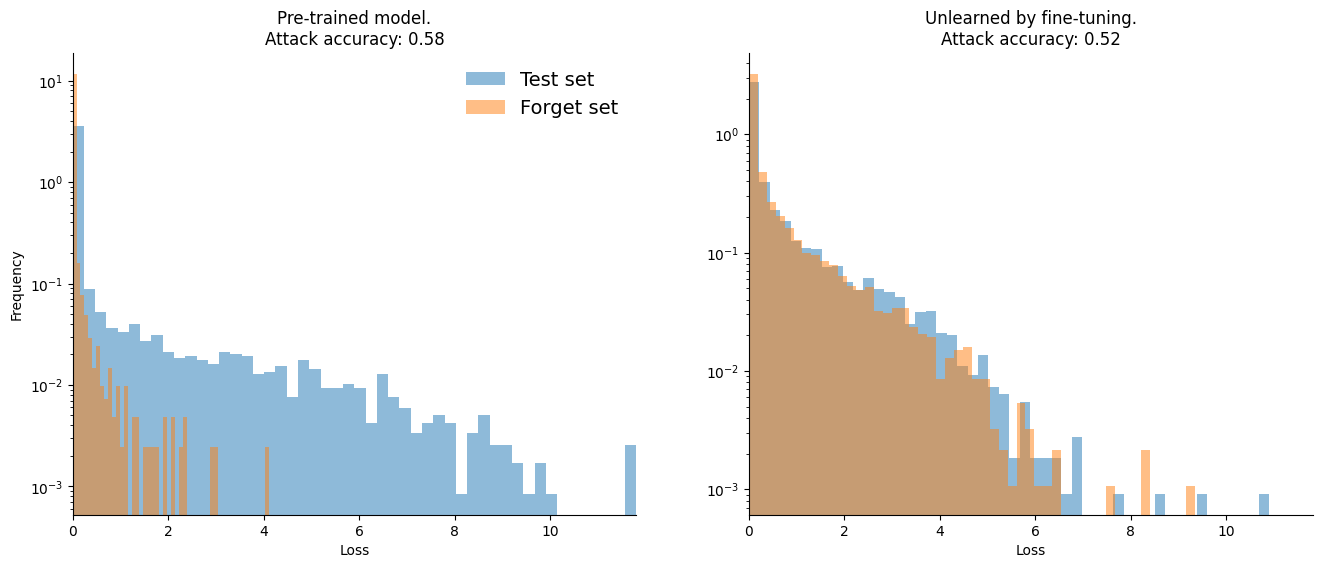

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [44]:
# download weights of a model trained exclusively on the retain set
local_path = "../example notebooks/weights/retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/retrain_weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 88.2%


In [45]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [46]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.496 on forgotten vs unseen images


As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

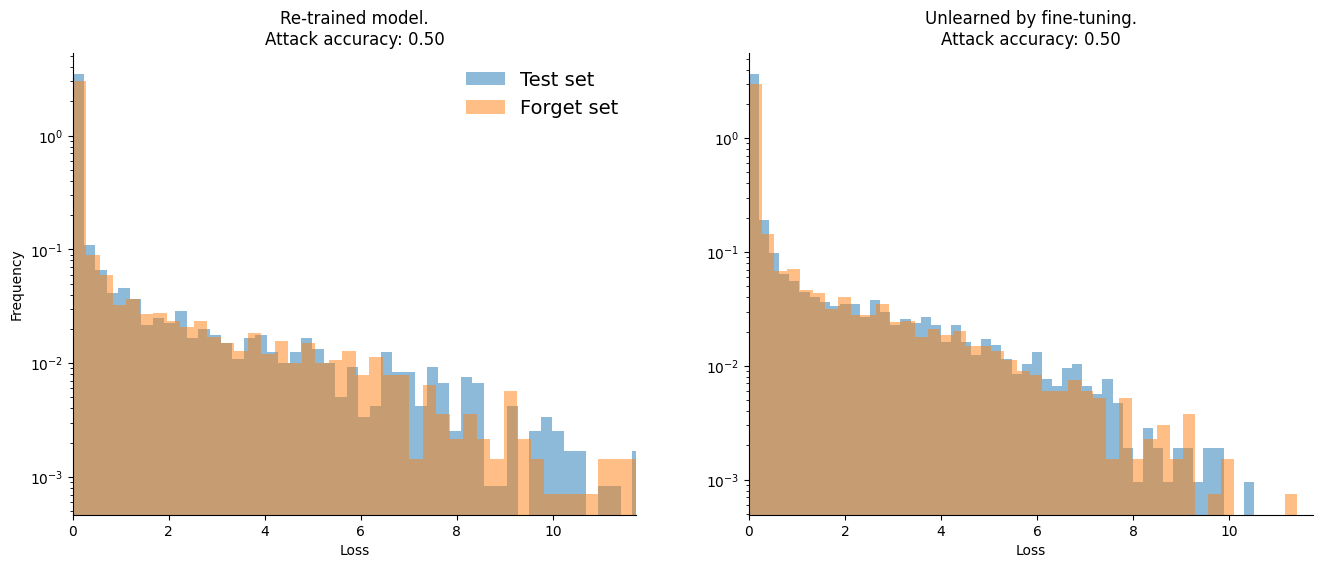

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()